# <center> Статистические тесты в контексте EDA. 
## <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Бизнес проблема.

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа мы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

- Если мы найдём в данных интересные закономерности, также отметьтим их в своём анализе.

Продемонстрируем использование разных тестов для проверки статистической значимости сделанных выводов:

- тесты для количественного признака:
    - для одной выборки;
    - для двух выборок;
    - для нескольких выборок;
- тест для категориальных признаков.

Мы будем использовать уровень значимости $\alpha$ - порог для оценки результата как статистически значимого. Если показатель значимости будет ниже уровня значимости, результат будет считается статистически значимым. 

__На каждый вопрос мы будем отвечать с уровнем значимости $\alpha=0.05$.__

Это значит, что вероятность случайного получения статистически значимого результата составляет менее 5% - т.е мы готовы в 5% допустить ошибку 1 рода - сделать вывод, что эффект есть, хотя на самом деле его нет.

Ошибка 1 рода - вероятность отклонить нулевую гипотезу, когда она верна.
***

У нас есть датасет с данными о зарплате в сфере Data Science за 2020–2022 годы. Датасет содержит следующие столбцы-параметры.

- work_year - Год, в котором была выплачена зарплата.
- experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
- employment_type - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- job_title - Роль, в которой соискатель работал в течение года.
- salary - Общая выплаченная валовая сумма заработной платы.
- salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
- employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
- company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

### Imports
Import libraries and write settings.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels import stats as sms
from wordcloud import WordCloud

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set aspects of the visual theme
sns.set_theme("notebook") # установка предварительных настроек маштабирования
sns.set_palette("husl") # установка предварительной световой палитры

In [2]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


# Analysis/Modeling

### Исследование структуры данных.

In [3]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.zip')
display(data)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [4]:
# Посмотрим размерность данных
display(data.shape)

(607, 12)

In [5]:
# Оценим информацию о датафрейме
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None

In [6]:
# Посмотрим статистическую информацию по всем столбцам
display(data.describe(include = 'all'))

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607.000000,607,607,607,6.070000e+02,607,607.000000,607,607.00000,607,607
unique,NaN,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,NaN,280,588,143,NaN,398,NaN,332,NaN,355,326
mean,303.000000,2021.405272,NaN,NaN,NaN,3.240001e+05,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,175.370085,0.692133,NaN,NaN,NaN,1.544357e+06,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,0.000000,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,151.500000,2021.000000,NaN,NaN,NaN,7.000000e+04,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,303.000000,2022.000000,NaN,NaN,NaN,1.150000e+05,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,454.500000,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.00000,NaN,NaN


In [7]:
# Поищем дубликаты. Предварительно создадим список столбцов dupl_columns, по которым 
# будем искать совпадения (все столбцы, не включая Unnamed: 0, т.к. он задает каждой 
# строке свой уникальный индентификатор). 
dupl_columns = list(data.columns)
dupl_columns.remove('Unnamed: 0')
# Создадим маску дубликатов с помощью метода duplicated() и произведём фильтрацию. 
# Результат заносим в переменную data_duplicates. Выведем число строк.
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 42


In [8]:
# Посмотрим пропуски
display(data.isnull().sum())

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

<hr style="border-style: dashed;">

У нас есть датасет со следующими данными:   
- размерность 607 строк и 12 параметров (столбцов)
- 5 параметров числовых: Unnamed: 0, work_year, salary, salary_in_usd, remote_ratio
- 7 категориальных: experience_level, employment_type, job_title, salary_currency, employee_residence, company_location, company_size
- в датасете 42 дубликата
- пропусков у нас нет

__Вывод__:  
Нам надо будет удалить параметр - 'Unnamed: 0', так как он не представляет для нас ценности и представляет из себя идентификатор строк датафрейма. Также надо удалить 42 найденных дубликата. Возможно нам надо будет перекодировать категориальные данные при более близком знакомстве с ними. При более близком знакомстве с параметрами возможно, еще что то удалим (кандидаты - salary, salary_currency) 
<hr style="border-style: dashed;">

In [9]:
# Удаляем столбец, дубликаты и сбросим индексы
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop_duplicates(subset=dupl_columns)
data = data.reset_index(drop=True)
print('Размер таблицы после удаления: {}'.format(data.shape))

Размер таблицы после удаления: (565, 11)


# <center> Проведем одномерный анализ данных

Мы исследуем каждый столбец и посмотрим распределение данных и другую информацию которую сможем найти. 
Сначала исследуем числовые данные, затем категориальнные.
    
## <center> Числовые данные

- work_year
- salary 
- salary_in_usd
- remote_ratio

    
#### Распределение зарплаты DS (salary_in_usd)
    
Так как нам надо сравнивать данные с зарплатой, то изучим общее распределение зарплат DS, как они располагаються с точки зрения наблюдений. Изучать мы будем столбец - salary_in_usd, так как здесь зарплата приведенна к обшему знаменателю.
Так как, мы хотим посмотреть распределение числового признака, то воспользуемся гистограммой.

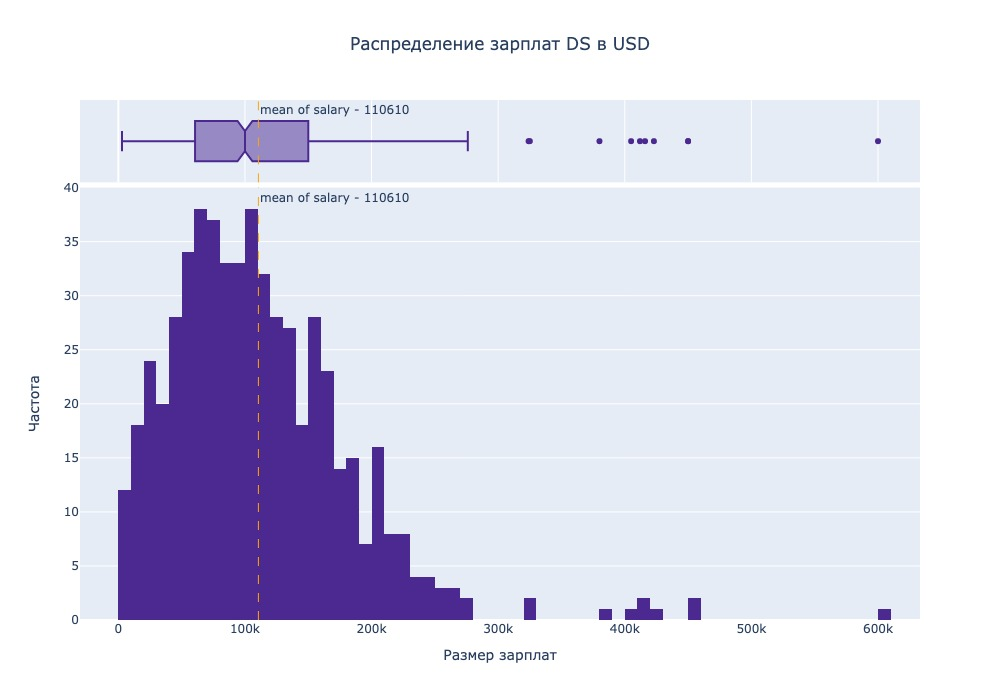

In [37]:
# Так как у нас зарплаты выплачиваються в разных валютах, у нас есть параметр который
# приводит все зарплаты в долларах - воспользуемся им.
fig = px.histogram(data, 
                    nbins=100,
                    x="salary_in_usd",
                    title="Распределение зарплат DS в USD",
                    color_discrete_sequence=px.colors.sequential.Agsunset,
                    width = 1000, 
                    height = 700, 
                    marginal='box',
                )

# Нарисуем линию среднего salary_in_usd
fig.add_vline(x=data['salary_in_usd'].mean(), 
              line_width=1,
              line_dash="dash", 
              annotation_text = 'mean of salary - 110610', 
              line_color="orange")

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Размер зарплат", 
                    yaxis_title="Частота",
                  )

fig.show('jpeg')
#fig.write_html("data/plotly/001_scheduling_salary_histogram.html")

In [11]:
# Посмотрим числовые характеристики
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат в USD']
data_agg

,Размер зарплат в USD
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


<hr style="border-style: dashed;">

__Вывод:__
- Распределение у нас ненормальное как видно по графику, не совпадает медианна (100 тысяч) и среднее (среднее - пунктирная зеленая линия 110610)  
- Крайние значения: слева - 2859, справа - 600 тысяч.
- Присутствуют выбросы

<hr style="border-style: dashed;">

#### Год, в котором была выплачена зарплата (work_year).

In [12]:
# Посмотрим признак
salary_year = data['work_year'].value_counts()
display(salary_year)

2022    278
2021    215
2020     72
Name: work_year, dtype: int64

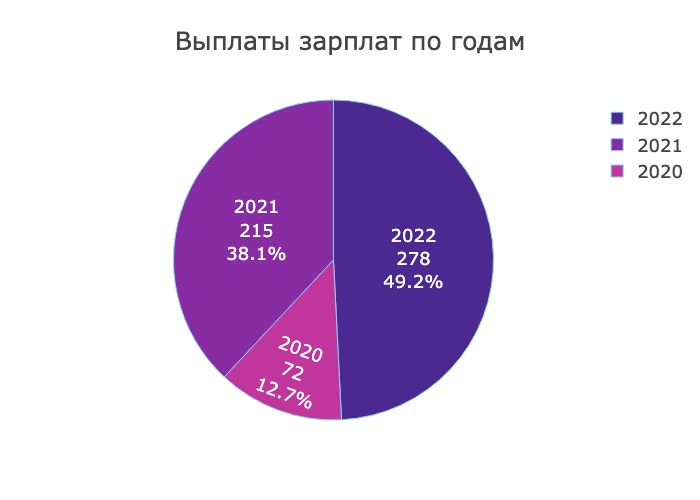

In [13]:
# Посмотрим пропорцию годов - выберем круговую диаграмму 
fig = px.pie(values=salary_year.values, 
             names=salary_year.index, 
             color_discrete_sequence=px.colors.sequential.Agsunset,
             title= 'Выплаты зарплат по годам',
             template='presentation'
            )

# Текст на графике
fig.update_traces(textinfo='label+percent+value', 
                  textfont_size=18,
                  marker=dict(line=dict(color='lightskyblue', width=1)))


fig.show('jpeg')
#fig.write_html("data/plotly/002_salary_year_pie.html")

<hr style="border-style: dashed;">

__Вывод:__   
Как видим около половины у нас занимает 2022 год, затем идет 2021 и замыкает 2020.

Могу предположить, что с 2020 года начался рост популярности профессий DS и начали массов набирать специалистов.
<hr style="border-style: dashed;">

#### Общая выплаченная валовая сумма заработной платы (salary)    
Данный столбец у нас также отражает зарплату, но здесь есть нюанс, он отражает зарплату в разных валютах. А валюты у нас храняться в категориальном столбце (salary_currency). 

In [14]:
# Посмотрим числовые характеристики
data_agg = data['salary'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат']
data_agg

,Размер зарплат
count,565.00
mean,338115.99
std,1599878.79
min,4000.00
25%,67000.00
50%,110925.00
75%,165000.00
max,30400000.00


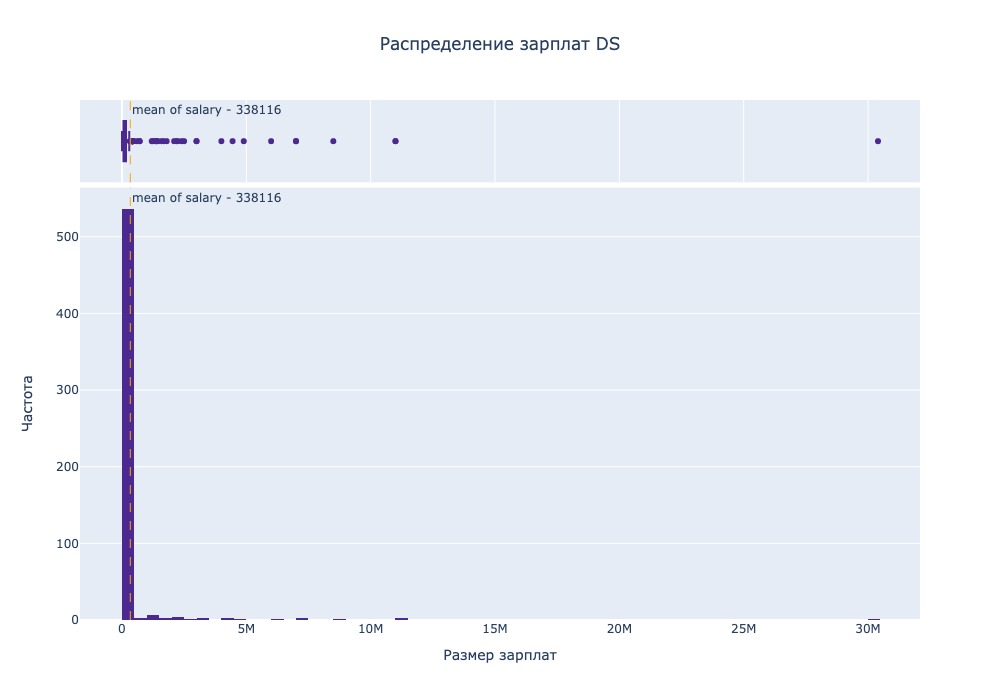

In [15]:
# Посмотрим распределение числового признака - выебрем гистограмму
fig = px.histogram(data, 
                    nbins=100,
                    x="salary",
                    title="Распределение зарплат DS",
                    width = 1000, 
                    height = 700, 
                    color_discrete_sequence=px.colors.sequential.Agsunset,
                    marginal='box',
                )

# Нарисуем линию среднего salary_in_usd
fig.add_vline(x=data['salary'].mean(), line_width=1, line_dash="dash", 
              annotation_text = 'mean of salary - 338116', 
              line_color="orange")

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Размер зарплат", 
                    yaxis_title="Частота",
                 )


fig.show('jpeg')
#fig.write_html("data/plotly/003_scheduling_salary_histogram.html")

<hr style="border-style: dashed;">

__Вывод:__   
- Как мы видим распределение не нормальное, медианна (110.9 тысяч) не совпадает со средним (338.1 тысяч)
- Крайние значения: слева - 4000, справа - 30.4 миллиона

Скорее всего данный столбец мы удалим.

<hr style="border-style: dashed;">


#### Общий объём работы, выполняемой удалённо (remote_ratio).

Возможные значения:
- 0 — удалённой работы нет (менее 20 %);
- 50 — частично удалённая работа;
- 100 — полностью удалённая работа (более 80 %).

Здесь как мы видим у нас есть 3 значения, которые обозначают сколько процентов работы приходиться выполнять удалленно.

In [16]:
# Посмотрим признак
remote_ratio = data['remote_ratio'].value_counts(ascending=True)
display(remote_ratio)

50      98
0      121
100    346
Name: remote_ratio, dtype: int64

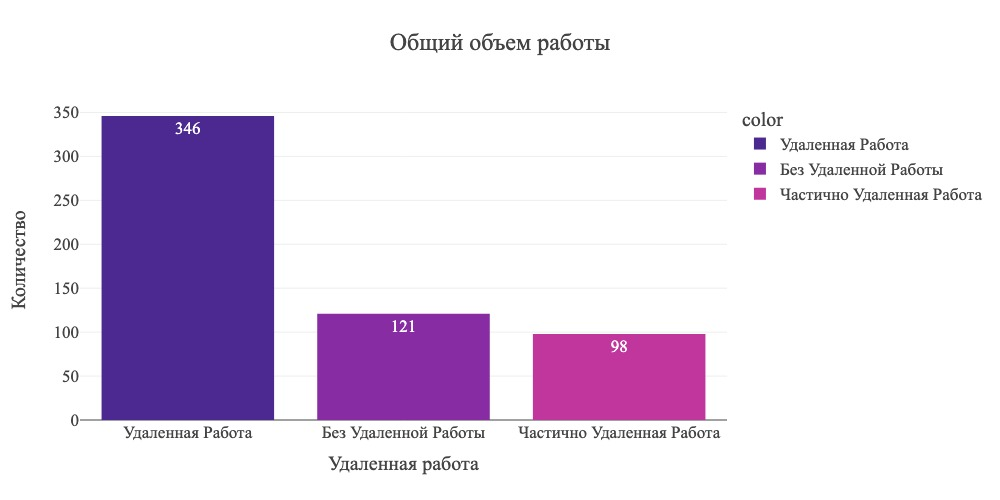

In [17]:
# Сравним наши данные визуально - используем для этого - столбчатую диаграмму
# Расшифруем категории для отображения столбцов работы и применим
work_type = ['Удаленная Работа', 'Без Удаленной Работы', 'Частично Удаленная Работа',]
# Графика
fig = px.bar(x = work_type, 
            y = data['remote_ratio'].value_counts().values,
            color = work_type,
            height=500, 
            width=1000,
            color_discrete_sequence=px.colors.sequential.Agsunset,
            text=data['remote_ratio'].value_counts().values,
            title = 'Общий объем работы',
            template='presentation')

fig.update_layout(
    xaxis_title="Удаленная работа",
    yaxis_title="Количество",
    font = dict(size=17,family="TimesNewRoman"))
fig.show('jpeg')
#fig.write_html("data/plotly/004_remote_ratio_bar.html")

<hr style="border-style: dashed;">

__Вывод:__   
Из графика мы видим, что большая часть работ выполняються удаленно.Скорее всего это связанно с наличием хорошего интернет-доступ, могу предположить, что возможно много DS берут заявки из-за границы (учитывая разные валюты оплаты) и работают из дома, либо в офисе но с заграничными клиентами.

<hr style="border-style: dashed;">


## <center> Категориальные данные

- experience_level
- employment_type
- job_title
- salary_currency
- employee_residence
- company_location
- company_size
    
#### Опыт работы на этой должности в течение года (experience_level)

Возможные значения:
- EN — Entry-level/Junior;
- MI — Mid-level/Intermediate;
- SE — Senior-level/Expert;
- EX — Executive-level/Director.

In [133]:
# Посмотрим данные
data['experience_level'].value_counts()

SE    243
MI    208
EN     88
EX     26
Name: experience_level, dtype: int64

In [125]:
# Посмотрим данные в процентном соотношение
exp_level=(data['experience_level'].value_counts(normalize=True)*100).round(2)
exp_level

SE    43.01
MI    36.81
EN    15.58
EX     4.60
Name: experience_level, dtype: float64

In [136]:
# Посмотрим визуально на пропорций уровней опыта - используем иерархическую диаграмму
# Для более корректного представления расшифруем сокращения должности,  заменив индексы
exp_level.index = (['Senior-level/Expert', 
                    'Mid-level/Intermediate',
                    'Entry-level/Junior', 
                    'Executive-level/Director'
                   ])

# График
fig = px.treemap(exp_level, 
                    path=[exp_level.index],
                    values=exp_level.values, 
                    title = 'Уровень опыта',
                    color=exp_level.index,
                    color_discrete_sequence=px.colors.sequential.Agsunset,
                    template='presentation',
                    width=1000, height=500
                )

# Текст на графике
fig.data[0].texttemplate = '%{label}<br>%{value}%'

fig.update_layout(
    font=dict(size=19,family="TimesNewRoman"))

fig.show('jpeg')
#fig.write_html("data/plotly/005_experience_level_treemap.html")

<hr style="border-style: dashed;">

__Вывод:__    
Как видим 43% это специалисты уровня Senior - можем предположить, что они закрывают большинство вопросов в данной сфере, возможно работают в одиночку, без команды. Далее у нас идет Midle, около 37%. Начинающих у нас 15.5% здесь скорее всего они только пришли в какие либо команды, либо выплняют низкооплачиваемые и простые заказы. Насчет директоров 4.6% - видимо здесь скорее всего работа в компаниях (командах), выполнение роли тимлида?

<hr style="border-style: dashed;">

#### Тип занятости (employment_type)

Возможные варианты: 

- PT — неполный рабочий день
- FT — полный рабочий день
- CT — контракт
- FL — фриланс

In [135]:
# Посмотрим признак
type_of_employment = data['employment_type'].value_counts()
type_of_employment

FT    546
PT     10
CT      5
FL      4
Name: employment_type, dtype: int64

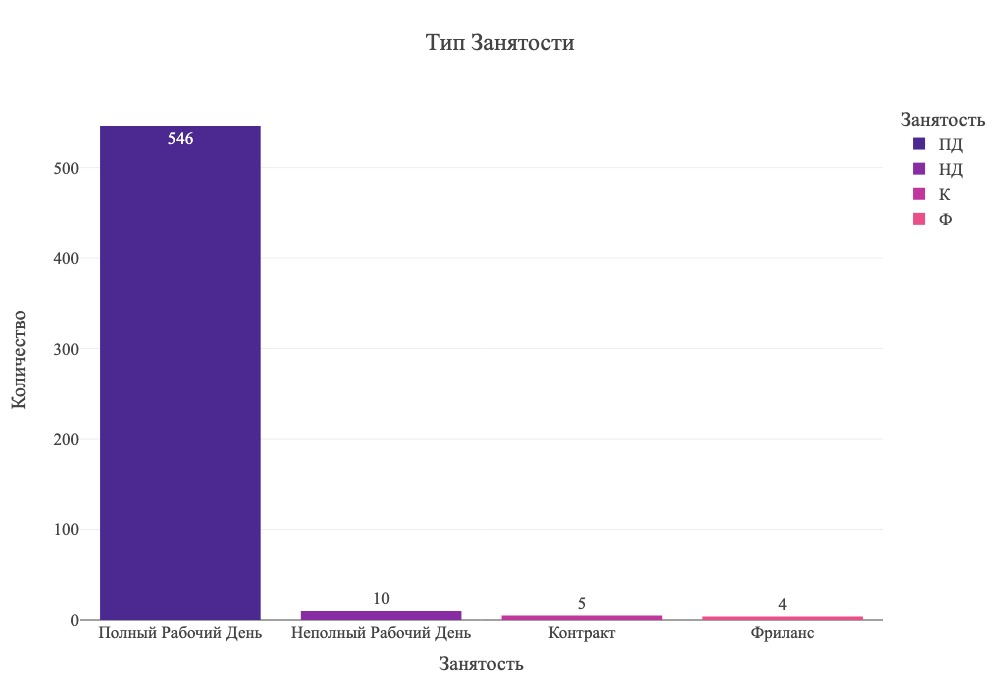

In [164]:
# Сравним наши данные визуально - используем для этого - столбчатую диаграмму
# Расшифруем сокращения занятости, заменив индексы
employment_type = ['Полный Рабочий День', 
                   'Неполный Рабочий День', 
                   'Контракт', 
                   'Фриланс']

# Для легенды обозначим сокращения
acronym = ['ПД', 'НД', 'К', 'Ф']

# Грфик
fig = px.bar(x = employment_type, 
            y = type_of_employment.values, 
            color = acronym, 
            color_discrete_sequence=px.colors.sequential.Agsunset,
            template = 'presentation',
            text = type_of_employment.values, 
            title = 'Тип Занятости',
            labels = {'color':'Занятость'},
            height = 700, 
            width = 1000
            )

# Название осей и шрифт
fig.update_layout(xaxis_title="Занятость",
                yaxis_title="Количество",
                font = dict(size=17,family="TimesNewRoman"))


fig.show('jpeg')
#fig.write_html("data/plotly/006_employment_type_bar.html")

<hr style="border-style: dashed;">

__Вывод:__    
Как видим большиство DS работают полный рабочий день, у 10 неполный рабочий день - возможно совмещают. На контракте у нас всего 5 человек - возможно директора ? И в свободном плавание 4 специалиста - здесь есть варинаты как джуны так и сеньоры. 

<hr style="border-style: dashed;">

#### Роль, в которой соискатель работал в течение года (job_title)

Здесь видимо имеется ввиду должность сотрудника.

In [180]:
# Посмотрим на данные
job_title = data['job_title'].value_counts()
job_title

Data Scientist               130
Data Engineer                121
Data Analyst                  82
Machine Learning Engineer     39
Research Scientist            16
                            ... 
Big Data Architect             1
Finance Data Analyst           1
Marketing Data Analyst         1
Machine Learning Manager       1
Data Analytics Lead            1
Name: job_title, Length: 50, dtype: int64

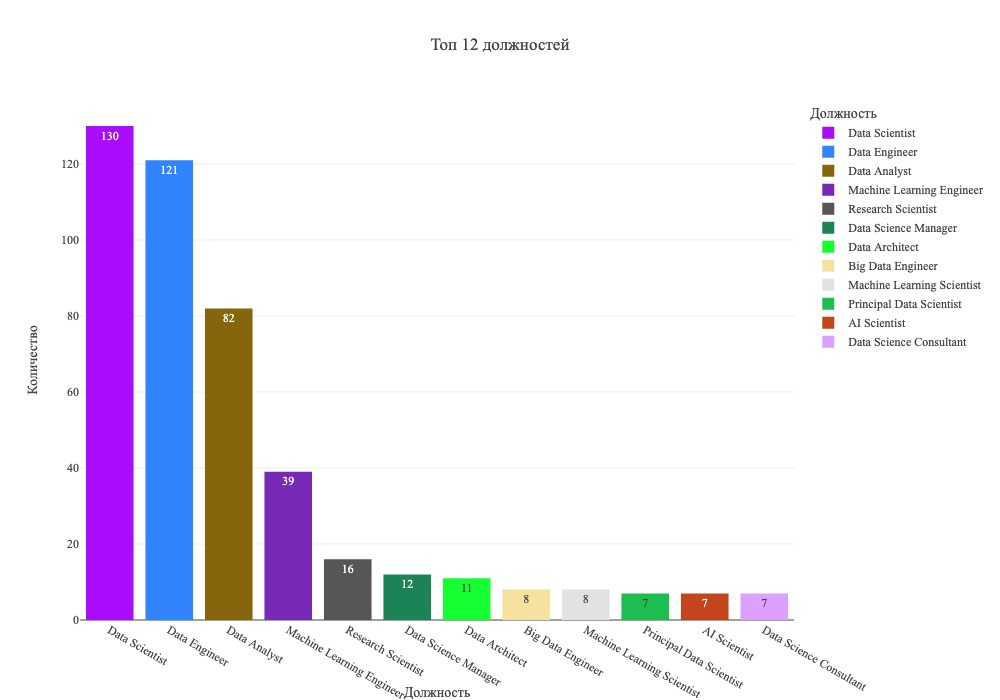

In [205]:
# Посмотрим наши структуру данных визуально - воспользуемся столбчатой диаграммой  
# Так как у нас 50 должностей, то мы посмотрим топ 12
job_title_top12 = data['job_title'].value_counts()[:12]

# График
fig = px.bar(x = job_title_top12.index, 
                y = job_title_top12.values,
                color = job_title_top12.index,
                color_discrete_sequence=px.colors.qualitative.Alphabet,
                text = job_title_top12.values,
                title = 'Топ 12 должностей',
                template = 'presentation',
                height = 700, 
                width = 1000,
                labels={'color':'Должность'}
            )
fig.update_layout(xaxis_title="Должность",
                    yaxis_title="Количество",
                    font = dict(size=12,family="TimesNewRoman")
                 )

fig.show('jpeg')
#fig.write_html("data/plotly/007_job_title_bar.html")

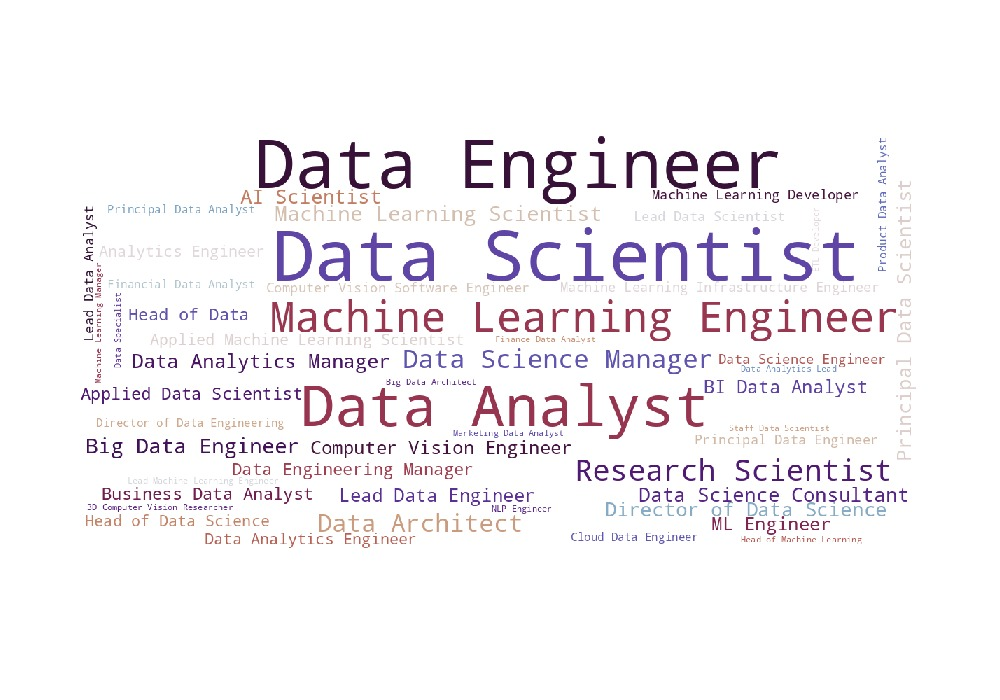

In [287]:
# Сделаем облако слов, чтобы было понятно и красиво
# Генерируем и настраиваем облако слов и сохраняем в переменной cloud
cloud = WordCloud(width=1200, 
                    height=600, 
                    max_words=50,
                    colormap='twilight',
                    max_font_size = 100,
                    random_state=88, 
                    background_color='white'
                ).generate_from_frequencies(job_title)

# Выводим облако на экран
fig = px.imshow(cloud,
                height = 700, 
                width = 1000
               )

# Отключаем отображение оси координат
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.show('jpeg')
#fig.write_html("data/plotly/008_job_title_WordCloud.html")

<hr style="border-style: dashed;">

__Вывод:__   
- 50 должностей
- топ 3: Data Scientist, Data Engineer, Data Analyst - составляют больше 50% количества должностей

Думаю топ 3 это основа DS - а другие должности уже проистекают отсюда с учетом углубления в какую либо специализацию либо специфики места работы.

<hr style="border-style: dashed;">

#### Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217 (salary_currency)

In [288]:
# Посмотрим данные
salary_currency = data['salary_currency'].value_counts()
salary_currency

USD    359
EUR     93
GBP     43
INR     27
CAD     18
JPY      3
PLN      3
TRY      3
CNY      2
MXN      2
HUF      2
DKK      2
SGD      2
BRL      2
AUD      2
CLP      1
CHF      1
Name: salary_currency, dtype: int64

In [289]:
# Спарсим с википедий коды валют 

,currency,per,date,time,close,vol,proportion
0,USD,D,29/12/17,00:00,57.6291,0,1
1,USD,D,30/12/17,00:00,57.6002,0,1
2,USD,D,31/12/17,00:00,57.6002,0,1
3,USD,D,01/01/18,00:00,57.6002,0,1
4,USD,D,02/01/18,00:00,57.6002,0,1
...,...,...,...,...,...,...,...
5659,AZN,D,02/12/19,00:00,37.7729,0,1
5660,AZN,D,03/12/19,00:00,37.9662,0,1
5661,AZN,D,04/12/19,00:00,37.8073,0,1
5662,AZN,D,05/12/19,00:00,37.8396,0,1


In [35]:
# Цветовые схемы
fig = px.colors.sequential.swatches()
fig.show()

In [46]:
# Цветовые схемы
fig = px.colors.qualitative.swatches()
fig.show()

In [47]:
# Темы по уомлчанию
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here

In [ ]:
data